<a href="https://colab.research.google.com/github/CaioLSouza/my_portfolio/blob/main/Fraudes_em_cart%C3%B5es_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção de Fraudes em Cartões de Crédito

Um dos problemas de ordem financeira mais comuns e importantes que acometem o Brasil e o mundo são as fraudes em cartões de crédito. Para se ter uma ideia, cerca de 2,8 milhões de tentativas de fraude em cartões de crédito foram feitas no primeiro semestre de 2022, sendo que as fraudes em bancos e cartões correspondem a cerca de 50% do total de fraudes efetuadas no país. Além disso, esse número tende a aumentar à medida em que a sociedade passa a utilizar menos dinheiro físico e mais cartões de crédito, principalmente em compras online. Por isso, é claro que esse problema acarreta em grandes prejuízos financeiros, seja para os bancos, seja para os consumidores. Até o final do ano, fraudes bancárias devem gerar um prejuízo de ao menos R$ 2,5 bilhões.

Dessa forma, é óbvio que as instituições financeiras buscam meios de minimizar esses prejuízos. Em geral, isso é feito com sistemas automatizados que são capazes de detectar o mais prontamente possível a ocorrência dessas fraudes. Dentre essas ferramentas, metódos de machine learning estão sendo muito utilizados por empresas de cartão de crédito e instituições financeiras. Eles mostram um ótimo desempenho relativo porque são capazes de identificar padrões complexos entre dados e conseguem lidar com uma enorme quantidade de dados, algo essencial na era do *big data*. 

Por isso, esse projeto busca utilizar alguns métodos de machine learning para prever a ocorrência de fraude em cartões de crédito a partir de um conjunto de dados real disponibilizado publicamente. 

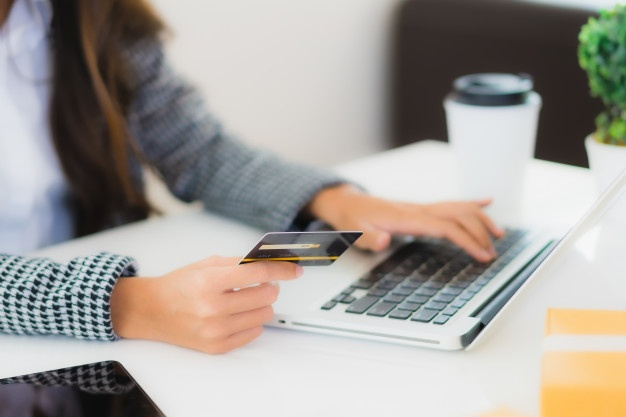

## Explicação do problema

O conjunto de dados utilizado foi disponibilizado por algumas empresas européias de cartão de crédito. Ele contém quase 290 mil transações, das quais apenas 492 foram fraudulentas. Além disso, ele contém 31 variáveis informativas, onde uma delas informa se a transação foi fraudulenta ou legítima.

O objetivo geral será classificar, a partir de informações fornececidas por essas variáveis, se uma determinada operação de cartão de crédito é ou não é fraudulenta. Trata-se, portanto, de um problema típico de machine learning supervisionado para classificação. 

Assim, nossa principal finalidade é detectar o maior número possível de casos em que há ocorrência de fraude.

### Importando módulos e bibliotecas necessárias

In [69]:
# manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style()
%matplotlib inline

# padronização dos dados
from sklearn.preprocessing import StandardScaler

# métricas de performance
from sklearn.metrics import precision_score, recall_score, f1_score,confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_recall_curve

# modelos de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 

# validação
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict

# divisão entre treino e teste
from sklearn.model_selection import train_test_split


### Importando os dados

Nesse conjunto de dados disponibilizado, por razões de privacidade, quase todas as variáveis foram ocultadas, todas elas já estão padronizadas e não há a presença de valores ausentes.

Além disso, o método *Principal Component Analysis* (PCA) foi utilizado para redução de dimensionalidade dos dados. Nesse contexto, esse método permite que as variáveis menos informativas disponíveis possam ser descartadas, restando apenas aquelas que são mais importantes para a previsão da variável resposta. Portanto, nesse cojunto de dados específico, 27 dessas variáveis foram selecionadas como as mais informativas. Sendo assim, o processo de seleção de variáveis já foi realizado e não será feito nessa análise.

Em suma, esses aspectos restringem a etapa de exploração de dados e pré-processamento de serem tratados, e o principal foco será a própria construção do modelo de machine learning.

Dadas essas considerações, podemos agora importar de fato o conjunto de dados (disponível no formato ``csv`` no link da célula abaixo) e transformá-lo em um *dataframe* do pandas.

In [2]:
# importar os dados
file_path = "https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1"

# importar os dados para um dataframe
df = pd.read_csv(file_path)

### Dicionário das variáveis

Como já foi explicado, 28 variáveis estão descaracterizadas para proteção de privacidade, denotadas por $[V1, V2, V3, \dots, V28]$. Além delas, temos outras três variáveis:
* ``V1`` até ``V28``: variáveis ocultadas.

* ``Time``: o instante de tempo em que uma operação foi realizada. Os dados levam em conta operações dentro de um intervalo de dois dias.

* ``Amount``: quantidade monetária da operação.

* ``Class``: classificação da operação em fraude ou não. Se igual a 0, a operação foi legítima. Se igual a 1, foi fraudulenta. Essa é, portanto, a variável resposta do modelo.

### Funções usadas no projeto

In [3]:
def plot_histogram(class_1, class_0, feature):
  # essa função cria dois histogramas para uma variável, um para cada uma das classes que uma observação pertence
  fig, (ax1, ax2) = plt.subplots(figsize=(15, 6), ncols=2)
  ax1.hist(x=feature, bins=32, data=class_1)
  ax1.set_title(f"Histograma para a variável {feature}: operações fraudulentas", weight='bold')
  ax2.set_title(f"Histograma para a variável {feature}: operações legítimas", weight='bold')
  ax2.hist(x=feature, bins=32, data=class_0)
  plt.tight_layout()

In [4]:
def compute_outliers(data, column):
  # essa função calcula os outliers para uma determinada variável
  iqr = data[column].quantile(q=0.75) - data[column].quantile(q=0.25)
  return data.loc[(data[column] < (data[column].quantile(q=0.25) - 1.5 * iqr)) | (data[column] > (data[column].quantile(0.75) + 1.5 * iqr))]

In [5]:
def plot_graph_confusion_matrix(y_test, y_pred):
  # essa função cria um heatmap com uma matriz de confusão
  matrix = confusion_matrix(y_test, y_pred)
  fig, ax = plt.subplots(figsize=(8, 5))
  sns.heatmap(matrix, annot=True, cmap='viridis', fmt='d')
  ax.set_xlabel('Previsto')
  ax.set_ylabel('Observado')
  plt.tight_layout()

In [63]:
def classification_metrics(y_test, y_pred):
  # essa função calcula as métricas acurácia, precisão, revocação e f1-score
  print(f'Acurácia: {accuracy_score(y_test, y_pred)}')
  print(f"Precisão: {precision_score(y_test, y_pred)}")
  print(f"Revocação: {recall_score(y_test, y_pred)}")
  print(f"f1_score: {f1_score(y_test, y_pred)}")

In [64]:
def metrics_cv(dictionary):
  # essa função mostra as métricas de classificação calculadas pela validação cruzada 
  for key, values in dictionary.items():
    print(key, np.mean(values))

In [65]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
  # essa função cria uma curva de precisão-revocação
  plt.plot(thresholds, precisions[:-1], 'b--', label='Precisão')
  plt.plot(thresholds, recalls[:-1], 'g-', label='Revocação')
  plt.xlabel('Threshold')
  plt.legend(loc='center left')
  plt.ylim([0, 1])

### Análise Exploratória


#### Visualizando as primeiras entradas do conjunto de dados

In [9]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Verificando dimensionalidade

Como já foi citado acima, temos 284807 observações e 31 variáveis no total.

In [10]:
# dimensionalidade dos dados
df.shape

(284807, 31)

#### Resumo estatístico geral

Um ponto interessante a ser notado nesse resumo estatístico é que para variável ``Amount``, o valor mínimo é de 0, o que provavelmente deve indicar algum tipo de erro. Esse problema será tratado logo adiante.


In [11]:
# resumo estatístico do dataframe
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### Verificando a presença de valores ausentes

Não há nenhum valor ausente no conjunto de dados.

In [12]:
# verificar se há valores ausentes 
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Verificando o balanceamento do dataset

Um dos grandes desafios em lidar com um problema de fraudes com cartões de crédito é a questão de como os dados estarão balanceados entre si. A quantidade de operações legítimas sempre será muito maior do que a de operações fraudulentas.

In [13]:
# verificar a proporção entre classes
print(f"{(len(df['Class'].loc[df['Class'] == 1]) / len(df)) * 100}%")

0.1727485630620034%


Podemos ver que apenas 0,17% das transações foram detectadas como fraudulentas.

Vamos agora visualizar isso com um *countplot*.

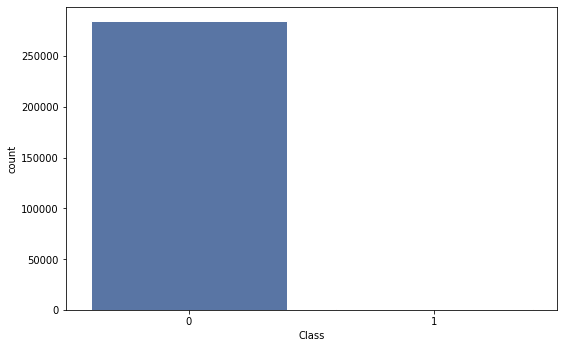

In [14]:
# criar um countplot para visualizar o balanceamento
fig, ax = plt.subplots(figsize=(8, 5))
sns.set_theme(style='darkgrid')
sns.countplot(x='Class', data=df)
plt.tight_layout()

Dados desbalanceados trazem alguns problemas com a construção de modelos de machine learning. 

Em primeiro lugar, como há uma classe que é completamente minoritária no conjunto de dados, o modelo de machine learning terá dificuldades em perceber a sua presença na análise de novas observações.

Além disso, a avaliação dos resultados obtidos também será dificultosa. Imagine, por exemplo, um modelo que diga que todas as observações do conjunto de dados são legítimas, sem ocorrência de fraude. Obviamente, tal modelo é completamente inútil, pois não é capaz de cumprir o grande objetivo do problema: detectar fraudes em cartões de crédito. Entretanto, se calcularmos a acurácia dele (a taxa total de acertos), iriamos obter incríveis 99,83%!



### Visualizando algumas distribuições de frequência.

Agora, vamos visualizar algumas distribuições de frequência e compará-las para as duas classes disponíveis.


In [15]:
# criar um conjunto separado para classes positivas e negativas
class_1 = df.loc[df['Class'] == 1]
class_0 = df.loc[df['Class'] == 0]

#### Distribuição: variável ``Time``

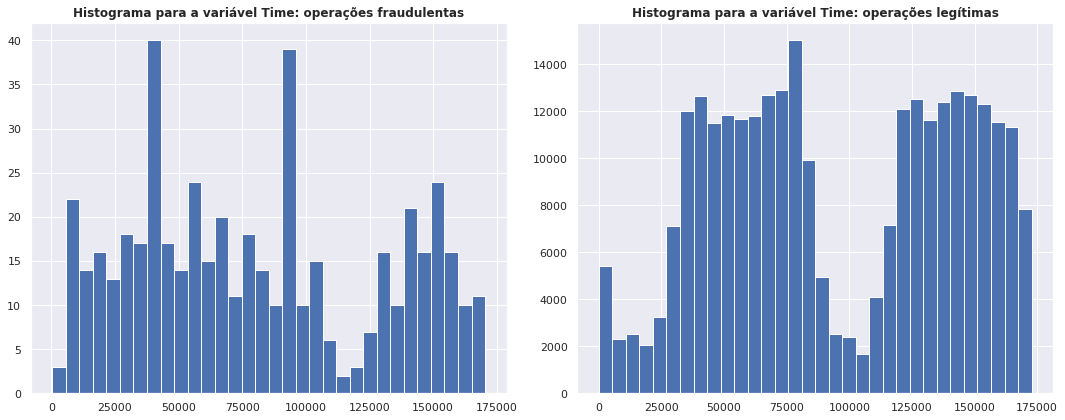

In [16]:
plot_histogram(class_1, class_0, 'Time')

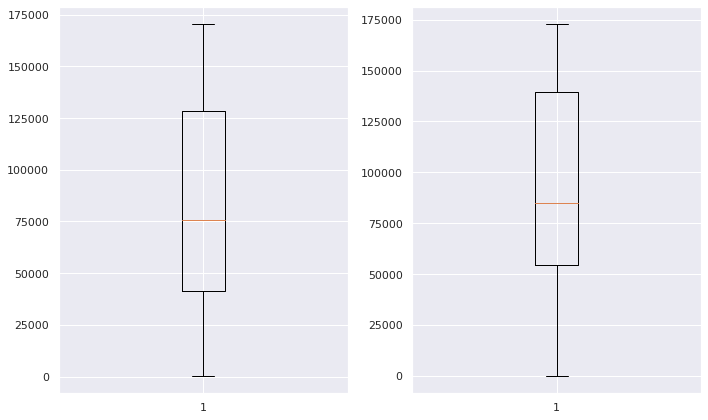

In [17]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols=2)
ax1.boxplot(x='Time', data=class_1)
ax2.boxplot(x='Time', data=class_0)
plt.tight_layout()

#### Mais algumas distribuições

Vamos visualizar mais três histogramas para as variáveis ``V17``, ``V14`` e ``V11``, que, como poderá ser visto mais adiante, possuem uma correlação significativa com a variável resposta. É claro que, dada a descaracterização dessas variáveis, não se pode obter muitas informações a partir disso, mas é visível que há uma diferença entre as distribuições para cada variável entre as duas classes.


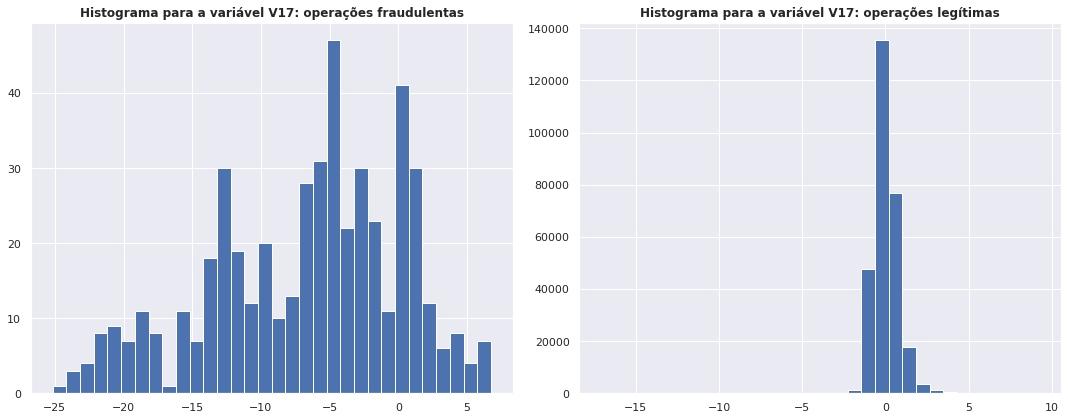

In [18]:
plot_histogram(class_1, class_0, 'V17')

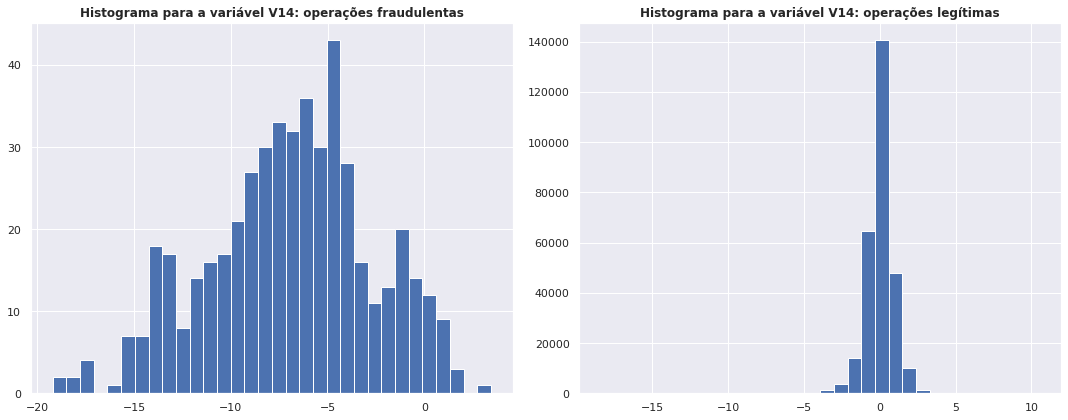

In [19]:
plot_histogram(class_1, class_0, 'V14')

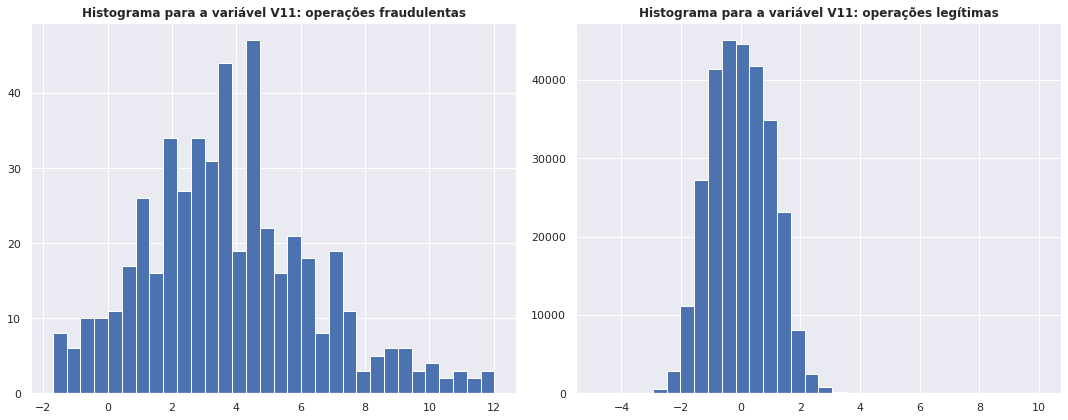

In [20]:
plot_histogram(class_1, class_0, 'V11')

#### Distribuição de frequência: variável ``Amount``

Agora, vamos analisar como as distribuições da quantidade de dinheiro das operações se diferenciam entre as operações fraudulentas e as operações legítimas.

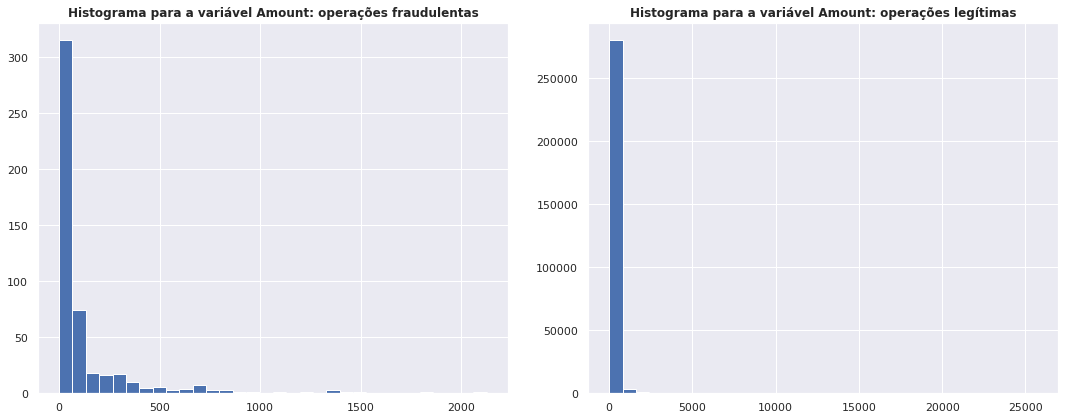

In [21]:
plot_histogram(class_1, class_0, 'Amount')

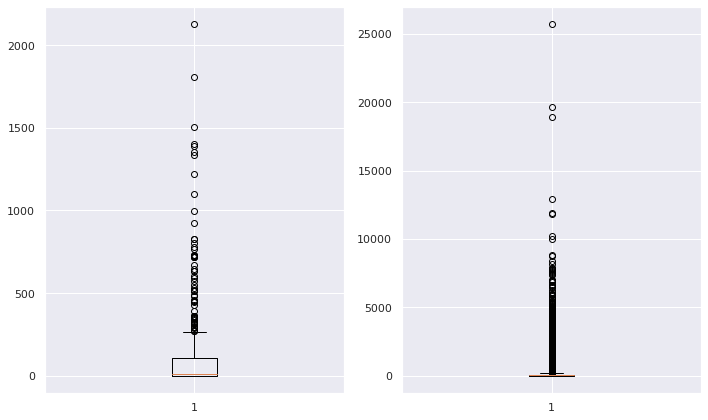

In [22]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols=2)
ax1.boxplot(x='Amount', data=class_1)
ax2.boxplot(x='Amount', data=class_0)
plt.tight_layout()

A visualização dos gráficos está sendo dificultada por alguns outliers, que estão afetando muito a escala da visualização. Vamos, então, retirar temporariamente esses outliers apenas para visualizar melhor as distribuições.

### Outliers

Para identificar os outliers, utilizamos a regra do IQR, *interquantile range*, que calcula a presença de outliers baseado no conceito de intervalo interquantil. 

Calculamos primeiro o primeiro quartil (Q1) (isto é, o valor para o qual 25% das observações da variável observada são menores do que ele) e depois o terceiro quartil (Q3) (a mesma lógica, mas aplicada ao valor de 75%). A diferença entre esses dois valores é igual ao IQR.

Por fim, uma observação é considerada um outlier se ela cumpre uma das duas condições abaixo:

* Q1 - 1.5 x IQR

* Q3 + 1.5 x IQR


Vamos ver qual a proporção dos outliers no conjunto de dados.

In [23]:
# proporção de outliers
print(f"Conjunto de dados: {round(len(compute_outliers(df, 'Amount')) / len(df) * 100, 2)}%")
print(f"Operações legítimas: {round(len(compute_outliers(class_0, 'Amount')) / len(class_0) * 100, 2)}%")
print(f"Operações fraudulentas: {round(len(compute_outliers(class_1, 'Amount')) / len(class_1) * 100, 2)}%")

Conjunto de dados: 11.2%
Operações legítimas: 11.21%
Operações fraudulentas: 14.02%


In [24]:
# removendo outliers
class_0_corrected = class_0.drop(compute_outliers(class_0, 'Amount').index)
class_1_corrected = class_1.drop(compute_outliers(class_1, 'Amount').index)

Sem os outliers, a diferença se torna mais evidente. As operações legítimas parecem seguir, de forma mais pronunciada, uma distribuição de Pareto (claro que o maior número disponível de observações colabora com isso, mas mesmo se descontarmos esse efeito essa diferença persiste), enquanto que as operações fraudulentas não.

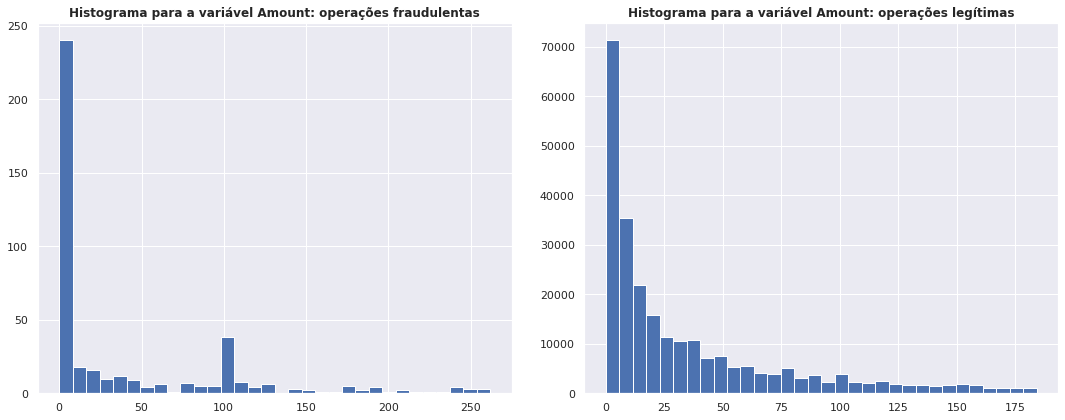

In [25]:
plot_histogram(class_1 = class_1_corrected, class_0 = class_0_corrected, feature='Amount')

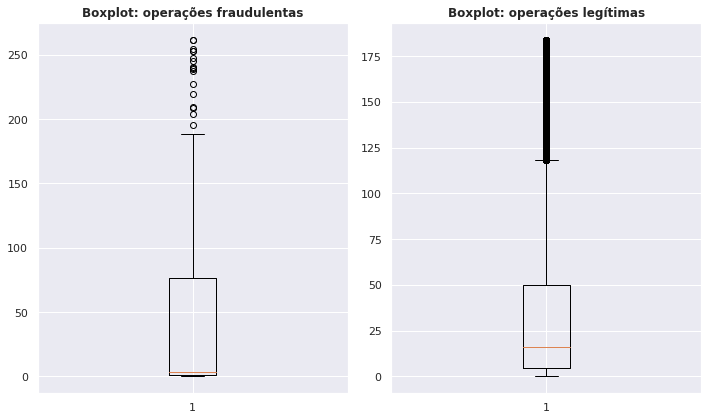

In [26]:
fig, (ax1, ax2) = plt.subplots(figsize=(10, 6), ncols=2)
ax1.boxplot(x='Amount', data=class_1_corrected)
ax1.set_title('Boxplot: operações fraudulentas', weight='bold')
ax2.boxplot(x='Amount', data=class_0_corrected)
ax2.set_title('Boxplot: operações legítimas', weight='bold')
plt.tight_layout()

### Resumo estatístico da variável ``Amount`` 

In [27]:
print("Operações legítimas:\n",round(class_0['Amount'].describe(), 2))
print("Operações fraudulentas:\n", round(class_1['Amount'].describe(), 2))

Operações legítimas:
 count    284315.00
mean         88.29
std         250.11
min           0.00
25%           5.65
50%          22.00
75%          77.05
max       25691.16
Name: Amount, dtype: float64
Operações fraudulentas:
 count     492.00
mean      122.21
std       256.68
min         0.00
25%         1.00
50%         9.25
75%       105.89
max      2125.87
Name: Amount, dtype: float64


Como se pode observar, a média de dinheiro gasto em operações fraudulentas é maior em relação às operações legítimas. Contudo, a mediana das operações legítimas é maior do que a das fraudulentas.

Além disso, operações legítimas aparentam assumir valores absolutos mais extremos. Enquanto o valor máximo das operações fraudulentas é de 2125, o valor máximo das operações legítimas é de 25691.

Por fim, como já foi dito, o valor mínimo é de 0.

### Excluindo prováveis erros

#### Valores iguais a zero

Vamos verificar qual a proporção de observações nulas em ``Amount`` no conjunto de dados, inclusive para cada classe separadamente.

In [28]:
print(df['Amount'].loc[df['Amount'] == 0].count() / df['Amount'].shape[0])

print(class_0['Amount'].loc[class_0['Amount'] == 0].count() / len(class_0))

print(class_1['Amount'].loc[class_1['Amount'] == 0].count() / len(class_1))

0.006407848121710491
0.006323971651161564
0.054878048780487805


Podemos ver que a proporção é pequena. Para as transações fraudulentas ela é mais significativa, pois abrange 5% das observações dessa classe. De qualquer maneira, a opção mais segura é excluir essas observações, pois provavelmente constituem algum erro ocorrido.

In [29]:
df = df.loc[df['Amount'] != 0]
class_0 = class_0.loc[class_0['Amount'] != 0]
class_1 = class_1.loc[class_1['Amount'] != 0]

#### Observações duplicadas


Outro possível problema comum em conjuntos de dados são observações duplicadas.

In [30]:
df.duplicated().astype(int).sum()

1064

Como se pode ver, possuímos 1064 observações duplicadas. Portanto, por se tratar de um erro, vamos removê-las também.

In [31]:
df = df.drop_duplicates()

### Correlações

Nós iremos agora analisar e visualizar algumas correlações entre as variáveis. A correlação considerada será a famosa correlação de Pearson, que busca medir o sentido e o grau de correlação linear que existe entre duas variáveis. Ela abrange valores de -1 a 1. O valor 1 significa uma correlação linear positiva perfeita, -1 representa uma correlação negativa perfeita e o valor 0 significa uma correlação linear nula entre as variáveis.

Sendo assim, vejamos uma lista com a correlação entre as variáveis explanatórias e a nossa variável resposta.


In [32]:
df_corr = df.corr()
df_corr['Class'].sort_values(ascending=False)

Class     1.000000
V11       0.145334
V4        0.126041
V2        0.082979
V19       0.035825
V8        0.034943
V21       0.028161
V27       0.021790
V20       0.020028
V28       0.009177
Amount    0.006632
V22       0.005107
V26       0.003791
V25       0.003075
V15      -0.002564
V13      -0.003268
V23      -0.006674
V24      -0.007084
Time     -0.013080
V6       -0.042688
V5       -0.089712
V9       -0.090130
V1       -0.094012
V18      -0.105803
V7       -0.169793
V3       -0.179695
V16      -0.186845
V10      -0.202874
V12      -0.245823
V14      -0.285683
V17      -0.312380
Name: Class, dtype: float64

Como se pode observar, a variável ``V17`` é a que possui maior correlação negativa com a classe das operações, enquanto a ``V11`` é a com maior correlação positiva.

A variável ``Amount``, por exemplo, tem uma correlação quase nula, mas isso não significa que ela não seja importante para prever se uma operação é fraudulenta ou não, pois a correlação de Pearson é restrita a correlações *lineares*.

### Excluindo a variável ``Time``

A variável ``Time`` não parece ser importante para se prever a legitimidade ou não das operações, nem do ponto de vista intuitivo nem analisando suas distribuições de frequência ou correlação vistas anteriormente. Portanto, iremos excluí-la do conjunto de dados.

In [33]:
df = df.drop('Time', axis=1)
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


## Dividindo entre treino e teste

O conjunto de teste será configurado em 20% do conjunto de dados, o que corresponde a 56384 observações.

In [34]:
y = df['Class']
X = df.drop('Class', axis=1)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [36]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((225534, 29), (225534,), (56384, 29), (56384,))

In [37]:
df.Class.loc[df.Class == 0].count() / df.shape[0]

0.9984108854347719

## Padronizando os dados

Agora que os dados foram divididos entre treino e teste, podemos padronizá-los. Essa etapa não poderia ser realizada antes poque teríamos o problema do *data leakage*, isto é, estaríamos nos aproveitando de informações nos dados de teste para o treinamento do modelo.

Todas as variáveis do conjunto de dados já vieram padronizadas, faltando apenas a variável ``Amount``.

Embora a padronização não seja necessário para todos os modelos de machine learning, ela é especialmente importante para modelos baseados em distância.

In [38]:
# escalando o conjunto de treinamento 
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)


# escalando o conjunto de teste
X_test = scaler.transform(X_test)

## Métricas de Avaliação 

Antes de aplicarmos os métodos de machine learning para o conjunto de dados, é necessário escolher quais métricas serão uitilizadas para avaliar o desempenho dos resultados do modelo.

Como já foi dito, embora seja natural pensar na acurácia (taxa total de acertos do modelo) ela não é uma boa medida de desempenho para problemas com classes desbalanceadas. Por isso, utilizaremos outras métricas de desempenho, que são:

* A precisão: dentro do contexto desse problema, busca responder a seguinte pergunta: das vezes em que o modelo detectou uma possível fraude, em qual proporção ele estava correto, isto é, realmente ocorreu fraude?

* Sensibilidade (ou revocação): das vezes em que realmente houve fraude, em qual proporção o modelo conseguiu detectá-la?

* F1-score: é a média harmônica entre a precisão e a sensibilidade.

Olhando para o contexto do problema, a sensibilidade é particularmente importante, pois um erro medido por ela significa um caso onde houve fraude, mas ela não foi detectada. Isso tem um custo significativo para a empresa e para o cliente. Um erro medido pela precisão, diferentemente, significa um caso onde o modelo detectou uma fraude, mas trata-se de um "alarme falso". Embora isso também prejudique a empresa e o cliente, não é algo tão grave quanto o caso anterior.

### Treinamento e Avaliação

Agora podemos começar de fato construir e treinar os modelos de machine learning. Para começar, vamos contruir dois modelos simples: uma regressão logística e uma árvore de classificação, sem levar em consideração outros problemas que tornariam os modelos mais complexos.

#### Um modelo simples



In [39]:
simple_log = LogisticRegression()

simple_log.fit(X_train, y_train)

simple_log_preds = simple_log.predict(X_test)

classification_metrics(simple_log_preds, y_test)

Acurácia: 0.9992196367763905
Precisão: 0.6304347826086957
Revocação: 0.8529411764705882
f1_score: 0.725


In [40]:
simple_tree = DecisionTreeClassifier()

simple_tree.fit(X_train, y_train)

simple_tree_preds = simple_tree.predict(X_test)

classification_metrics(y_test, simple_tree_preds)

Acurácia: 0.9992905788876277
Precisão: 0.8023255813953488
Revocação: 0.75
f1_score: 0.7752808988764044


Como se pode ver pelos resultados, a regressão logística obteve um resultado superior quanto à métrica revocação, enquanto a árvore de classificação obteve uma precisão e um f1-score superiores.

#### Balanceamento dos Dados

Como foi delineado, o desbalanceamento presente no conjunto de dados pode acarretar em alguns problemas no desempenho dos modelos de machine learning. Assim, a solução utilizada para esse trabalho foi a *class weight*. Essa abordagem altera a função de custo do modelo, fazendo com que erros na classe minoritária sejam mais penalizados do que erros na majoritária. Isso permite que o modelo seja mais sensível à presença de observações da classe minoritária, melhorando seu desempenho. A penalidade para a classe minoritária varia de 0 a 1, onde 1 representa um modelo que apenas se preocupe com erros nessa classe, enquanto 0 um modelo que leve em consideração apenas erros na classe majoritária.

Assim, para escolher os melhores valores possíveis para a penalidade, foi realizada um *grid search*, com validação *Stratified K-Fold*, escolhendo o melhor *f1_score* possível dentro do intervalo entre 0 e 1.




In [41]:
model = LogisticRegression()

In [42]:
weights = np.linspace(0.0, 0.99, 200)

param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

gridsearch = GridSearchCV(estimator = model,
                          param_grid = param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, scoring='f1').fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'F1 Score para cada peso')

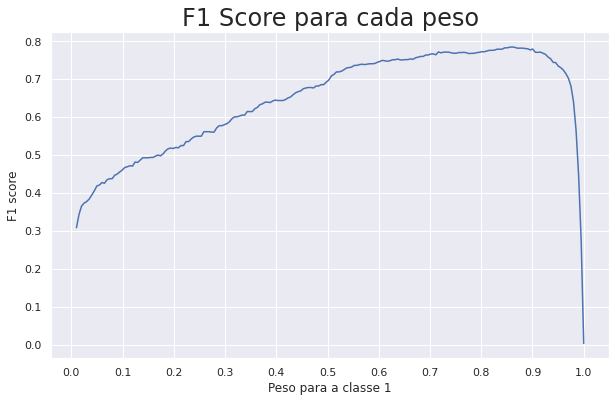

In [43]:
plt.figure(figsize=(10, 6))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sns.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Peso para a classe 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('F1 Score para cada peso', fontsize=24)

A partir do gráfico, é observável que a melhor combinação possível está em torno de 0,9/0,1.

Nós podemos agora estimar o desempenho desse modelo através de uma validação cruzada. O desempenho de todos os modelos serão estimados por ela, pois, como será detalhado posteriormente, se houver uma grande diferença entre a precisão e a revocação será possível se utilizar do existente *tradeoff* entre essas duas métricas.


In [44]:
lr = LogisticRegression(class_weight = {0: 0.1, 1: 0.9})

In [45]:
log_reg_validation = cross_validate(estimator = lr, X = X_train, y = y_train, scoring = ['f1', 'precision', 'recall'], cv = StratifiedKFold())

In [46]:
metrics_cv(log_reg_validation)

fit_time 2.22800350189209
score_time 0.09852709770202636
test_f1 0.7799882789559696
test_precision 0.7557656196052516
test_recall 0.8062597809076681


#### Treinamento -- regressão logística

Por fim, aplicamos ao modelo ao conjunto de testes e obtemos o resultado.

In [47]:
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)

#### Resultado -- Regressão Logística

Os resultados da regressão logística são resumidos a seguir.

In [48]:
classification_metrics(y_test, lr_preds)

Acurácia: 0.9992551078320091
Precisão: 0.7659574468085106
Revocação: 0.782608695652174
f1_score: 0.7741935483870968


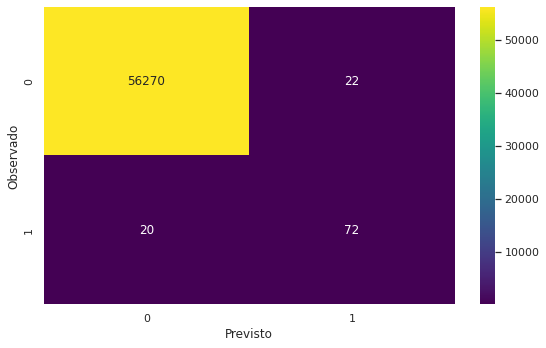

In [49]:
plot_graph_confusion_matrix(y_test, lr_preds)

## Decision Tree

O segundo modelo treinado será uma árvore de classificação. Os hiperparâmetros serão deixados no modo padrão do scikit-learn. 

In [81]:
tree = DecisionTreeClassifier(random_state=42, class_weight={0: 0.1, 1: 0.9})

In [82]:
tree_validation = cross_validate(estimator = tree, X = X_train, y = y_train, scoring = ['f1', 'precision', 'recall'], cv = StratifiedKFold())

In [83]:
metrics_cv(tree_validation)

fit_time 18.590527057647705
score_time 0.059585046768188474
test_f1 0.7448679383001103
test_precision 0.7593240294651585
test_recall 0.7332159624413146


In [54]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.1, 1: 0.9}, random_state=42)

In [55]:
tree_preds = tree.predict(X_test)

#### Resultados Decision Tree

Os resultados da árvore de decisão são resumidos a seguir.

In [56]:
classification_metrics(y_test, tree_preds)

Acurácia: 0.9992905788876277
Precisão: 0.8170731707317073
Revocação: 0.7282608695652174
f1_score: 0.7701149425287357


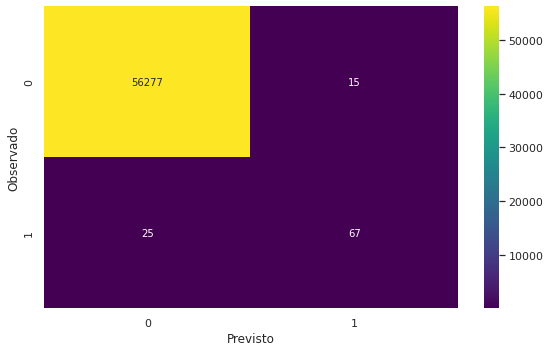

In [79]:
plot_graph_confusion_matrix(y_test, tree_preds)

O uso do class weight não teve um impacto significativo com a árvore de decisão. A diferença no f1-score é de apenas 1%, mas a diferença mais importante é que nesse caso a precisão aumentou e a revocação diminuiu em relação ao modelo sem o uso de class weight.

## Random Forest

In [57]:
rf_model = RandomForestClassifier(random_state=41, n_estimators=300, class_weight={0: 0.1, 1: 0.9})

In [58]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, n_estimators=300,
                       random_state=41)

In [59]:
rf_validation = cross_validate(estimator = rf_model, X = X_train, y = y_train, scoring = ['f1', 'precision', 'recall'], cv = StratifiedKFold())

In [60]:
metrics_cv(rf_validation)

fit_time 548.1115179538726
score_time 1.5288435459136962
test_f1 0.8442187805955033
test_precision 0.9350869722523727
test_recall 0.769640062597809


#### Escolhendo o melhor threshold

Esses resultados mostram que, para a random forest, há uma grande diferença entre a precisão e a revocação. Em problemas de classificação, existe um tradeoff entre precisão e revocação: podemos alterar o limite de decisão (o limite para o qual o modelo considera uma observação como pertencente a uma classe ou a outra) do modelo para aumentar a revocação e diminuir a precisão e vice-versa. 

Isso é útil especialmente para problemas como este, onde uma métrica possui mais impacto econômico do que a outra. Portanto, a partir disso, pode-se construir uma curva de compensação entre precisão e revocação que mostra os valores dessas duas métricas para diferentes limites de decisão. A partir dela, é possível selecionar os melhores valores dessas métricas que atendam ao objetivo de cada problema em particular.

Essa curva é construída também utilizando uma validação cruzada.

In [61]:
y_scores_rf = cross_val_predict(rf_model, X_train, y_train, cv=StratifiedKFold(), method='predict_proba')
y_scores_rf = y_scores_rf[:, 1]

In [70]:
from sklearn.metrics import precision_recall_curve
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(y_train, y_scores_rf)

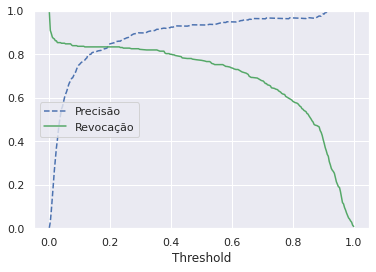

In [71]:
plot_precision_recall_curve(precisions_rf, recalls_rf, thresholds_rf)

O ponto onde as curvas as duas curvas se cruza, isto é, em torno de 0.2, foi o ponto escolhido. Mesmo com a revocação sendo uma métrica mais importante, a partir dessse thresolhd aumentar um pouco dela só pode ser feito mediante um sacríficio muito grande na precisão, algo que não é recompensador.

In [75]:
rf_prob_preds = rf_model.predict_proba(X_test)

In [76]:
rf_prob_preds = rf_prob_preds[:, 1]
rf_prob_preds[rf_prob_preds >= 0.2] = 1
rf_prob_preds[rf_prob_preds < 0.2] = 0

#### Resultados random forest

Os resultados para a random forest são os seguintes.

In [77]:
classification_metrics(y_test, rf_prob_preds)

Acurácia: 0.9995211407491487
Precisão: 0.8735632183908046
Revocação: 0.8260869565217391
f1_score: 0.8491620111731845


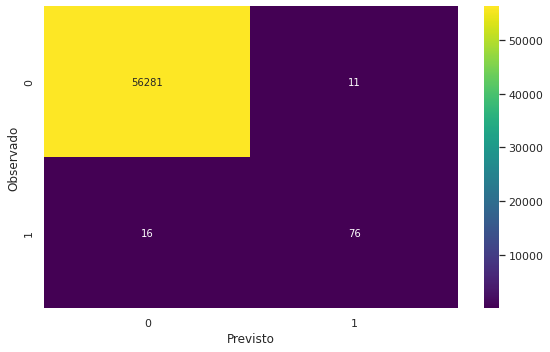

In [78]:
plot_graph_confusion_matrix(y_test, rf_prob_preds)

## Conclusões

De uma forma geral, a etapa mais complexa dentro desse trabalho foi a própria construção dos modelos de machine learning, especialmente ao levar em conta os problemas relacionados com o fortíssimo desbalanceamento dos dados. Dado isso,  ao compararmos os três modelos construídos, aquele que mostrou uma superioridade em aspectos gerais foi a random forest.

Por fim, levar em conta aspectos como modelos mais complexos ou o uso da otimização de hiperparâmetros poderiam aprimorar o desempenho obtido até agora com esse conjunto de dados. 